# 네이버 영화리뷰 감성분석 🎭

사용할 데이터:[ Naver sentiment movie corpus](https://github.com/e9t/nsmc)

## 1. 데이터 준비와 확인

In [1]:
# import urllib.request
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import os
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter

# 데이터를 로드
dir_path = dir_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data'
train_data = pd.read_table(os.path.join(dir_path, 'ratings_train.txt'))
test_data = pd.read_table(os.path.join(dir_path, 'ratings_test.txt'))

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성
다음의 기능을 수행하는 `data_loder`를 만든다.
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어

# 데이터 로더 함수 정의
def load_data(train_data, test_data, num_words=10000):
    # train data 전처리
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 특수문자 제거
    train_data['document'].replace('', np.nan, inplace=True)  # 공백은 Null로 변경
    train_data = train_data.dropna(how = 'any')  # 결측치 제거
    # test data 전처리
    test_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 특수문자 제거
    test_data['document'].replace('', np.nan, inplace=True)  # 공백은 Null로 변경
    test_data = test_data.dropna(how = 'any')  # 결측치 제거

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어사전 만들기
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)  # 단어 빈도순으로 (10000-4)개 가져오기
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  # 앞부분 4개 추가
    word_to_index = {word:index for index, word in enumerate(vocab)}  # {단어:인덱스} 단어사전 생성
    
    # 리뷰 텍스트를 단어사전 인덱스로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [4]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("train data 개수: {}, test data 개수: {}".format(len(X_train), len(X_test)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  


train data 개수: 145791, test data 개수: 48995


__index_to_word__ 함수

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

__Encode/Decode 함수__

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
# decode된 문장과 라벨을 비교하여 일치하는지 확인
for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('Label: ', y_train[i])

[27, 67, 895, 33, 214, 15, 28, 699]
더 빙 진짜 짜증 나 네요 목소리
Label:  0
[977, 481, 491, 636, 4, 110, 1554, 48, 866, 949, 11, 38, 364]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
Label:  1
[19, 192, 2]
재 <UNK>
Label:  0
[8035, 143, 4134, 277, 85, 13, 5, 52, 3326]
이야기 구먼 솔직히 재미 없 다 평점 조정
Label:  0
[2, 8488, 1051, 48, 2702, 54, 4, 2625, 34, 1118, 29, 326, 36, 17, 35, 54, 2, 2, 393, 2850, 1677, 5]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
Label:  1
[627, 2, 2, 425, 171, 1464, 661, 1592, 665, 46, 2, 4, 61, 2167, 118, 718]
<UNK> <UNK> 세 부터 초등 학교 학년 생 인 <UNK> 영화 ㅋㅋㅋ 별반 개 아까움
Label:  0
[237, 351, 8, 354, 1909, 51, 11, 780, 5]
긴장감 을 제대로 살려 내 지 못했 다
Label:  0
[232, 1344, 132, 5, 392, 705, 2, 2, 48, 1434, 269, 93, 233, 23, 882, 24, 321, 608, 501, 475, 546, 5, 3165, 8489, 17, 1386, 1386, 65, 282, 13, 5, 48, 95, 7, 70, 17, 2, 37]
반개 아깝 다 욕 나온다 <UNK> <UNK> 연기 생활 몇 년 인지 정말 발 로 해도 그것 보단 낫 겟 다 납치 감금 만 반복 반복 드라마 가족 없 다 연기 못 하 사람 만 <UNK> 네
Label:  0
[117, 13, 18, 85, 12, 269, 22, 43, 4]
없 는데 재미 있 

## 3. 모델 구성을 위한 데이터 분석 및 가공

### 3.1 데이터셋 내 문장 길이 분포
embedding 레이어의 input 이 되는 문장 벡터는 그 길이가 일정 해야 한다. 문장 최대 길이 maxlen의 값 설정은 전체 모델 성능에 영향을 미치게 되므로, 적절한 값을 찾기 위해서 전체 데이터 셋의 분포를 확인해본다.

문장길이 평균 :  13.757179674103888
문장길이 최대 :  83
문장길이 표준편차 :  11.462771769216866


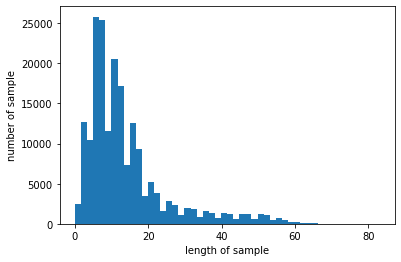

In [8]:
# 텍스트데이터 문장을 담은 리스트 생성
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

plt.fig=((12,6))
plt.hist([len(s) for s in total_data_text], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

### 3.2 적절한 최대 문장 길이 지정

In [9]:
# 최대 길이를 (평균 + 3*표준편차)로 지정  
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
max_len = int(max_tokens)
print('pad_sequences maxlen : ', max_len)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  48
전체 문장의 0.9726161017732281%가 maxlen 설정값 이내에 포함됩니다. 


### 3.3 패딩 추가
RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state값에 가장 영향을 많이 미치게 된다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율 적이다. 따라서 'pre' padding으로 진행한다.

In [10]:
# padding으로 문장 길이 맞추기
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='pre',
                                       maxlen=max_len)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='pre',
                                       maxlen=max_len)

print(X_train.shape)

(145791, 48)


## 4. 모델구성 및 validation set 구성

In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터), 단어 하나를 표현하는 임베딩 벡터의 차원 수

### 4.1 CNN

- 텍스트 처리를 하기위해 `1-D Convolution Neural Netword(1-D CNN)`를 사용할 수 있다.
- `1-D CNN`은 문장 체페를 한꺼번에 한 방향으로 길이 n짜리 필터로 스캐닝 하면서 n단어 이내에서 발견되는 특징을 추출하고, 그것으로 문장을 분류하는 방식으로 사용된다.
- CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다..

In [12]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.Conv1D(16, 3, activation='relu'))
model1.add(keras.layers.MaxPooling1D(5))
model1.add(keras.layers.Conv1D(16, 3, activation='relu'))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

### 4.2 LSTM

RNN은 시간의 흐름에 따라 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는 state machine으로 설계되었다.LSTM은 RNN의 문제를 해결하기 위해 나온 모델로 주로 사용되는 모델이다.

In [13]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.LSTM(8))# LSTM state 벡터의 차원수 (변경가능)
# model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 160,809
Trainable params: 160,809
Non-trainable params: 0
_________________________________________________________________


### 4.3 GlobalMaxPooling1D

아주 간단하게는 GlobalMaxPooling1D() 레이어 하나만 사용할 수 도 있다. 이 방식은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍/부정을 평가하는 방식이다.

In [14]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 훈련
1. train과 validation set으로 분리하고
2. 모델을 훈련시킨다,

In [15]:
# train, validation set 분리

# validation set 30000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 11만여 건
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(115791, 48)
(115791,)


### 5.1 CNN

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    callbacks=[es, mc], 
                    batch_size=60,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
1930/1930 [==============================] - 15s 6ms/step - loss: 0.5064 - accuracy: 0.7376 - val_loss: 0.3704 - val_accuracy: 0.8307
Epoch 2/20
1930/1930 [==============================] - 9s 5ms/step - loss: 0.3311 - accuracy: 0.8553 - val_loss: 0.3644 - val_accuracy: 0.8364
Epoch 3/20
1930/1930 [==============================] - 9s 5ms/step - loss: 0.2806 - accuracy: 0.8821 - val_loss: 0.3787 - val_accuracy: 0.8319
Epoch 4/20
1930/1930 [==============================] - 9s 5ms/step - loss: 0.2327 - accuracy: 0.9068 - val_loss: 0.4029 - val_accuracy: 0.8292
Epoch 5/20
1930/1930 [==============================] - 9s 5ms/step - loss: 0.1963 - accuracy: 0.9224 - val_loss: 0.4352 - val_accuracy: 0.8234
Epoch 6/20
1930/1930 [==============================] - 9s 5ms/step - loss: 0.1626 - accuracy: 0.9370 - val_loss: 0.4920 - val_accuracy: 0.8170
Epoch 00006: early stopping


In [17]:
# 학습이 끝난 모델을 테스트셋으로 평가
results1 = model1.evaluate(X_test,  y_test, verbose=2)
print(results1)

1532/1532 - 5s - loss: 0.4976 - accuracy: 0.8153
[0.49761152267456055, 0.8153076767921448]


### 5.2 LSTM

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    callbacks=[es, mc], 
                    batch_size=60,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
1930/1930 [==============================] - 21s 10ms/step - loss: 0.4828 - accuracy: 0.7666 - val_loss: 0.3501 - val_accuracy: 0.8448
Epoch 2/20
1930/1930 [==============================] - 19s 10ms/step - loss: 0.3260 - accuracy: 0.8584 - val_loss: 0.3387 - val_accuracy: 0.8490
Epoch 3/20
1930/1930 [==============================] - 19s 10ms/step - loss: 0.2944 - accuracy: 0.8709 - val_loss: 0.3396 - val_accuracy: 0.8487
Epoch 4/20
1930/1930 [==============================] - 19s 10ms/step - loss: 0.2662 - accuracy: 0.8825 - val_loss: 0.3511 - val_accuracy: 0.8502
Epoch 5/20
1930/1930 [==============================] - 19s 10ms/step - loss: 0.2435 - accuracy: 0.8941 - val_loss: 0.3632 - val_accuracy: 0.8474
Epoch 6/20
1930/1930 [==============================] - 19s 10ms/step - loss: 0.2233 - accuracy: 0.9043 - val_loss: 0.3830 - val_accuracy: 0.8472
Epoch 00006: early stopping


In [19]:
# 학습이 끝난 모델을 테스트셋으로 평가
results2 = model2.evaluate(X_test,  y_test, verbose=2)
print(results2)

1532/1532 - 6s - loss: 0.3881 - accuracy: 0.8455
[0.38813427090644836, 0.8454944491386414]


### 5.3  GlobalMaxPooling1D

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    callbacks=[es, mc], 
                    batch_size=60,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
1930/1930 [==============================] - 7s 4ms/step - loss: 0.5285 - accuracy: 0.7512 - val_loss: 0.3628 - val_accuracy: 0.8378
Epoch 2/20
1930/1930 [==============================] - 7s 3ms/step - loss: 0.3354 - accuracy: 0.8553 - val_loss: 0.3590 - val_accuracy: 0.8432
Epoch 3/20
1930/1930 [==============================] - 7s 3ms/step - loss: 0.2943 - accuracy: 0.8788 - val_loss: 0.3649 - val_accuracy: 0.8414
Epoch 4/20
1930/1930 [==============================] - 7s 3ms/step - loss: 0.2694 - accuracy: 0.8895 - val_loss: 0.3760 - val_accuracy: 0.8393
Epoch 5/20
1930/1930 [==============================] - 7s 3ms/step - loss: 0.2500 - accuracy: 0.8982 - val_loss: 0.3883 - val_accuracy: 0.8380
Epoch 6/20
1930/1930 [==============================] - 7s 4ms/step - loss: 0.2336 - accuracy: 0.9065 - val_loss: 0.4012 - val_accuracy: 0.8352
Epoch 00006: early stopping


In [21]:
# 학습이 끝난 모델을 테스트셋으로 평가
results3 = model3.evaluate(X_test,  y_test, verbose=2)
print(results3)

1532/1532 - 2s - loss: 0.4072 - accuracy: 0.8333
[0.40724995732307434, 0.8332687020301819]


__모델들의 Loss, Accuracy 결과 요약__

In [22]:
loss = [l for l, a in [results1, results2, results3]]
accuracy = [a for l, a in [results1, results2, results3]]
df_score = pd.DataFrame({'Loss':loss, 'Accuracy':accuracy}, index=['CNN','LSTM','GMP'])
df_score

,Loss,Accuracy
CNN,0.497612,0.815308
LSTM,0.388134,0.845494
GMP,0.407250,0.833269


LSTM >GMP>CNN  순으로 정확도가 높다.

## 6. Loss, Accuracy 그래프 시각화

### 6.1 CNN

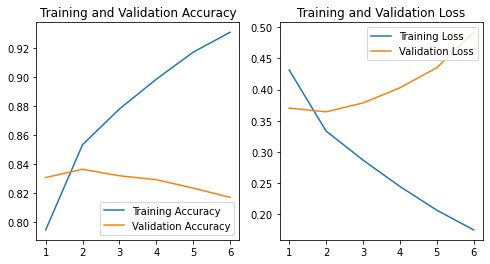

In [23]:
# 시각화할 항목 세팅
history_dict1 = history.history
acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 6.2 LSTM

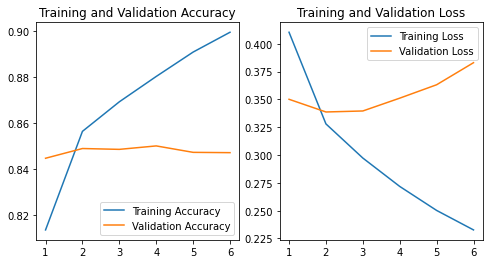

In [24]:
# 시각화할 항목 세팅
history_dict2 = history2.history
acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 6.3 GlobalMaxPooling1D¶

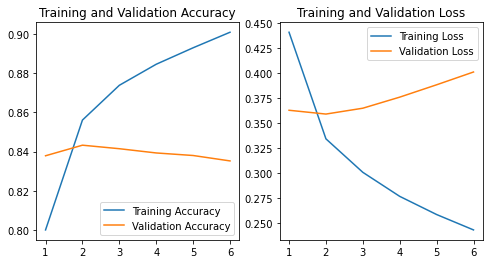

In [25]:
# 시각화할 항목 세팅
history_dict3 = history3.history
acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 7. 학습된 Embedding 레이어 분석
gensim을 활용하여 자체학습한 임베딩을 분석한다.

In [26]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

In [27]:
def get_word2vec_file(model,word2vec_file_path):
    # 임베딩 레이어 차원 확인
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]

    # 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    return None

In [28]:
word2vec_file_path1 = os.getenv('HOME')+f'/aiffel/sentiment_classification/data/word2vec_cnn.txt'
word2vec_file_path2 = os.getenv('HOME')+f'/aiffel/sentiment_classification/data/word2vec_lstm.txt'
word2vec_file_path3 = os.getenv('HOME')+f'/aiffel/sentiment_classification/data/word2vec_fgm.txt'

get_word2vec_file(model1,word2vec_file_path1)
get_word2vec_file(model2,word2vec_file_path2)
get_word2vec_file(model3,word2vec_file_path3)

In [29]:
# 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors1 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path1, binary=False)
vector1 = word_vectors1['흥미']

word_vectors2 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path2, binary=False)
vector2 = word_vectors2['흥미']

word_vectors3 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path3, binary=False)
vector3 = word_vectors3['흥미']

print('[CNN]','='*70)
print(vector1)
print('[LSTM]','='*70)
print(vector2)
print('[GlobalMaxPooling]','='*60)
print(vector3)

[CNN] ======================================================================
[ 0.048485    0.01485831 -0.16239728 -0.02188365 -0.05323372 -0.12305791
  0.00376066 -0.07885681 -0.1506061  -0.0644417   0.03170481  0.04300391
  0.08490143 -0.21343201  0.07515167  0.03413675]
[LSTM] ======================================================================
[-0.02795721 -0.01163287 -0.277858    0.04540787  0.07680692  0.14896825
  0.07891765  0.04098464  0.05311748  0.02650332  0.18659636  0.06386492
 -0.09221812  0.11430349 -0.06221066 -0.19736138]
[GlobalMaxPooling] ============================================================
[ 0.07708497 -0.04082032 -0.16625877 -0.14810935 -0.16013025 -0.1421849
  0.02987054 -0.02099461  0.11836415 -0.16351235 -0.16209981 -0.19762892
 -0.16918008 -0.00301806 -0.17824039 -0.16871032]


워드 벡터가 의미벡터 공간상에 유의미하게 학습되었는지 확인하기위해 유사도를 확인해본다.

In [30]:
print('[CNN]','='*70)
print(word_vectors1.similar_by_word("흥미"))
print('[LSTM]','='*70)
print(word_vectors2.similar_by_word("흥미"))
print('[GlobalMaxPooling]','='*60)
print(word_vectors3.similar_by_word("흥미"))

[CNN] ======================================================================
[('늑대인간', 0.817611575126648), ('조진웅', 0.8063798546791077), ('잼', 0.7755563259124756), ('켄', 0.7665939331054688), ('순간', 0.7644432783126831), ('엄청나', 0.7609978318214417), ('다던', 0.7542583346366882), ('패밀리', 0.7528819441795349), ('드러내', 0.7504660487174988), ('골고루', 0.7485338449478149)]
[LSTM] ======================================================================
[('로얄', 0.9443776607513428), ('넘길', 0.9406064748764038), ('메세지', 0.9396376609802246), ('민감', 0.9271429777145386), ('죤', 0.9262378811836243), ('재미', 0.9196140766143799), ('긴장감', 0.9190269112586975), ('라던지', 0.9181056022644043), ('대략', 0.9098988771438599), ('으라', 0.9088629484176636)]
[GlobalMaxPooling] ============================================================
[('드디어', 0.8997805118560791), ('다시', 0.8961628675460815), ('완', 0.8900470733642578), ('역시', 0.8893264532089233), ('언어', 0.8863126039505005), ('형', 0.8799445629119873), ('이전', 0.8776841759681702), (

'흥미' 단어의 유사단어 결과를 가지고 각 모델을 비교해본다.
전체적으로 유사한 단어들로 결과물을 뱉어 주지않는 것으로 보아 정확도 83%에 비해 크게 좋은 결과를 내어주지는 못한다. 그래도 영화 리뷰로 만들어진 것을 감안하고 결과물을 해석해보면 각 모델마다 '흥미'와 연관있는 단어들을 찾아 볼 수 있다. __CNN__ 모델은 '늑대인간', '조진웅' 같은 관련단어들이 있고, __LSTM__ 은 '로얄','긴장감' 등, __GlobalMaxPooling__ 에서는 '드디어', '긴장' 등이 유사단어로 잘 나왔다.

사전학습된 워드 임베딩 모델을 활용하여 벡터를 정교하게 학습시켜본다.

## 8. 한국어 Word2Vec 임베딩 활용하여 성능개선
네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성하기

한국어 Word2Vec 임베딩 모델
- [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)

In [31]:
# 사용하기 위해서 필요한 spec에 따라 라이브러리 버전 조정
# pip install --upgrade gensim==3.8.3

In [32]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko_tar/ko.vec'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path)
vector = word2vec['흥미']
vector.shape

(200,)

In [33]:
word2vec.similar_by_word("흥미")

[('호기심', 0.6089121103286743),
 ('관심', 0.5792118310928345),
 ('취미', 0.5322762131690979),
 ('상상력', 0.5259734392166138),
 ('재미있', 0.524858832359314),
 ('매력', 0.5103601813316345),
 ('재미', 0.502285897731781),
 ('관심사', 0.48539993166923523),
 ('실감', 0.47706544399261475),
 ('해박', 0.47447964549064636)]

학습이 잘되어 유사한 단어들을 결과물로 준다. 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜본다.

In [34]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [35]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

In [37]:
# 모델 구성
model_wv = keras.Sequential()
model_wv.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_len, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_wv.add(keras.layers.LSTM(128))
# model_wv.add(keras.layers.Dense(8, activation='relu'))
model_wv.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model_wv.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [38]:
# 학습 진행
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_wv.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_wv = model_wv.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    callbacks=[es, mc], 
                    batch_size=60,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
1930/1930 [==============================] - 38s 19ms/step - loss: 0.4577 - accuracy: 0.7769 - val_loss: 0.3330 - val_accuracy: 0.8513
Epoch 2/20
1930/1930 [==============================] - 32s 17ms/step - loss: 0.3207 - accuracy: 0.8613 - val_loss: 0.3205 - val_accuracy: 0.8593
Epoch 3/20
1930/1930 [==============================] - 31s 16ms/step - loss: 0.2876 - accuracy: 0.8789 - val_loss: 0.3066 - val_accuracy: 0.8663
Epoch 4/20
1930/1930 [==============================] - 30s 15ms/step - loss: 0.2625 - accuracy: 0.8911 - val_loss: 0.3081 - val_accuracy: 0.8678
Epoch 5/20
1930/1930 [==============================] - 31s 16ms/step - loss: 0.2417 - accuracy: 0.9002 - val_loss: 0.3075 - val_accuracy: 0.8683
Epoch 6/20
1930/1930 [==============================] - 30s 16ms/step - loss: 0.2163 - accuracy: 0.9126 - val_loss: 0.3245 - val_accuracy: 0.8631
Epoch 7/20
1930/1930 [==============================] - 30s 15ms/step - loss: 0.1905 - accuracy: 0.9241 - val_loss: 0.3332 -

In [39]:
# 테스트셋을 통한 모델 평가
results = model_wv.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 6s - loss: 0.3425 - accuracy: 0.8607
[0.3424859344959259, 0.8607204556465149]


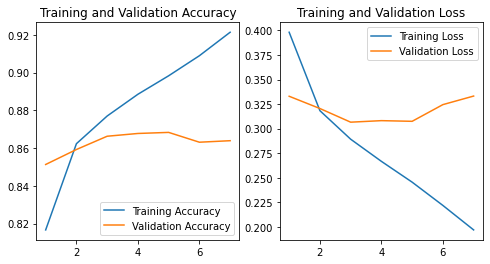

In [40]:
# 시각화할 항목 세팅
history_dict = history_wv.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 9. 리뷰 예측하기

생성된 영화 감성 분류기가 리뷰를 잘 분류해주는지 테스트 해본다.<br>
테스트 해볼 문장들은 Naver영화의 [오만과 편견](https://movie.naver.com/movie/bi/mi/point.naver?code=44728)의 네티즌 평점에서 가져왔다.

In [61]:
reviews = ['내가 본 로맨스 영화 중에서 최고라 말할 수 있을 듯.',
'영화전체적인 분위기가 너무 좋아요. 다아시 너무 매력있네요 감추지 못하는 그 감정이 눈빛에 다 드러나서 너무 설렜어요.',
'요즘에 나오는 로맨스 영화와는 달리 선정적이지 않고 ㅅ과하지 않으면서도 정말 아름 답게 사랑을 표현해서 좋았다. 그리고 중간중간 등장하는 멋진 자연경관이 영화에 조미료가 되어 더욱더 풍부한 영화였던것 같다.',
'아직도 키이라 나이틀리를 보면 엘리자베스 베넷이 떠오른다. 내게 여운이 긴 영화',
'지금까지 10번정도 본 거같다. 그럼에도 질리지 않는 무한의 마력이 있는 것 같다 이 영화는..',
'지루해 죽는지 알았네',
'그냥 내용속도가 너무 빨랐고다시 사서 봤는데 마지막 마무리도 어설펐고 그냥그랬던 영화 의외로 낮지 않은 평점이라 더 놀램',
'오만가지 생각이 다 들고과연 이 영화가 인생 영화라고 하는 인간은편가르기 하자는건지 아니면견해가 없는건지.. 내가 책을 안 읽어봐서그런건지 걍 오만과편견을 가지게 만듬오만과편견 오행시였음.',
'이해할수 없는 내용.. 과대평가된 영화',
'매매혼, 못생기면 무시당하고 잘생기고 부자여야 한눈에 뿅가고.이게 최고의 로멘스 맞아요?? 이거 최악의 로멘스인거 같은데?',
'BBC와 비교해보면 떨어지는 연기, 연출']

In [41]:
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

In [95]:
def sentiment_predict(review):
    review_raw = review
    review = review.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 특수문자 제거
    review = tokenizer.morphs(review) # 토큰화
    review = [word for word in review if not word in stopwords]
    encoded = wordlist_to_indexlist(review) # 정수 인코딩
    encoded = [encoded]
    pad_review = pad_sequences(encoded,value=word_to_index["<PAD>"], padding='pre',maxlen=max_len)
    score = float(model_wv.predict(pad_review)) # 예측
    
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100),review_raw)
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100),review_raw)

In [96]:
for review in reviews:
    sentiment_predict(review)
    print('='*70)

97.67% 확률로 긍정 리뷰입니다.
 내가 본 로맨스 영화 중에서 최고라 말할 수 있을 듯.
98.79% 확률로 긍정 리뷰입니다.
 영화전체적인 분위기가 너무 좋아요. 다아시 너무 매력있네요 감추지 못하는 그 감정이 눈빛에 다 드러나서 너무 설렜어요.
98.51% 확률로 긍정 리뷰입니다.
 요즘에 나오는 로맨스 영화와는 달리 선정적이지 않고 ㅅ과하지 않으면서도 정말 아름 답게 사랑을 표현해서 좋았다. 그리고 중간중간 등장하는 멋진 자연경관이 영화에 조미료가 되어 더욱더 풍부한 영화였던것 같다.
80.53% 확률로 긍정 리뷰입니다.
 아직도 키이라 나이틀리를 보면 엘리자베스 베넷이 떠오른다. 내게 여운이 긴 영화
98.74% 확률로 긍정 리뷰입니다.
 지금까지 10번정도 본 거같다. 그럼에도 질리지 않는 무한의 마력이 있는 것 같다 이 영화는..
99.79% 확률로 부정 리뷰입니다.
 지루해 죽는지 알았네
70.98% 확률로 부정 리뷰입니다.
 그냥 내용속도가 너무 빨랐고다시 사서 봤는데 마지막 마무리도 어설펐고 그냥그랬던 영화 의외로 낮지 않은 평점이라 더 놀램
98.76% 확률로 부정 리뷰입니다.
 오만가지 생각이 다 들고과연 이 영화가 인생 영화라고 하는 인간은편가르기 하자는건지 아니면견해가 없는건지.. 내가 책을 안 읽어봐서그런건지 걍 오만과편견을 가지게 만듬오만과편견 오행시였음.
99.67% 확률로 부정 리뷰입니다.
 이해할수 없는 내용.. 과대평가된 영화
95.07% 확률로 부정 리뷰입니다.
 매매혼, 못생기면 무시당하고 잘생기고 부자여야 한눈에 뿅가고.이게 최고의 로멘스 맞아요?? 이거 최악의 로멘스인거 같은데?
91.29% 확률로 부정 리뷰입니다.
 BBC와 비교해보면 떨어지는 연기, 연출


11 문장 중 11 문장의 분류가 모두 정확하다😊

***

## 프로젝트 정리

- 1-D CNN, LSTM, GlobalMaxPolling으로 모델을 설계하였다. 정확도는 약 81~84% 수준이었고 LSTM > CNN > GMP 순으로 정확도가 높았다.
- epoch은 20번으로 지정해 두고, 검증 데이터 손실(val_loss)이 증가하면 과적합 징후므로 4회 이상 증가하는 경우 학습을 조기 종료하게하였다.
- gensim의 `similar_by_word`로 자체학습한 임베딩과 사전학습 임베딩 결과를 비교하였다. '흥미'라는 단어로 결과를 비교해봤는데, 자체 학습한 모델들은 '흥미'와는 상관없어 보이는 단어들을 결과로 내어주는 경우가 많았다. fastText는 호기심, 관심, 취미, 상상력, 재미있, 매력등 '흥미'와 유사도가 높은 단어들을 결과로 보여주어 사전학습이 잘 이루어진 것을 확인할 수 있었다.
- fastText 파일안에는 모델과 벡터 두가지를 제공하는데 모델파일은 인코딩에러로 열리지 않아 벡터를 이용해서 진행하였다. 이번 프로젝트에서는 학습된 벡터를 가지고 결과를 비교해보는 것이여서 벡터로도 충분하였지만 추가적인 학습을 하려면 모델을 이용해서 진행할 수 있다고 한다. 
- 사전 모델이 결과로 내어준 유사 단어 결과를 보고 모델 성능이 크게 향상될거라 기대했지만 결과는 생각보다 크게 향상하지는 않았다. 그래도 목표하던 85% 이상은 달성하였다.
- 최종 모델이 리뷰를 얼마나 잘 예측하는지 궁금하여 리뷰를 넣어주면 분류 결과를 내주는 함수를 만들어 테스트 해보았다. 결과를 보면 11문장의 긍부정 분류는 100%로 분류를 매우 잘 해주는 것을 볼 수 있다.👍